# Modelo de ML

## Importación de librerías

In [3]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import f1_score, make_scorer, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

import warnings
warnings.filterwarnings('ignore')

## Carga y transformacion de los datos

In [5]:
#Se cargan las reviews de Darden
path_data = '../data/clean'
reviews = pd.read_parquet(f'{path_data}/reviews_darden.parquet')
reviews_negativas = reviews[reviews.stars<=3]
reviews_negativas.head()

,name,review_id,user_id,business_id,stars,text,date,day,text_reply,city,state,postal_code,coordinates
0,Cheddar's Scratch Kitchen,_nM2IN_PleArpBRKzbq2Jg,G5nBrEuXyVMYPwD9cVtN4g,3kCdCzbfMbpTStmrUbpfUQ,1.0,The service was terrible. My wife's meal came ...,2019-09-18,Wednesday,,Tampa,PA,33618,"28.048990114,-82.505071509"
1,Yard House,3D_YF1igbVDUr23jmjrSyQ,9mk2G2NK6UbShCpWYP_79A,bSX7czEHT7plB0JG_2aPHg,2.0,"Kitchen was very slow, 2 out of 8 meals serve...",2020-02-17,Monday,,Willow Grove,PA,19090,"40.1402883373,-75.1249255505"
2,Cheddar's Scratch Kitchen,ONKAoN-Zhpq0l2KLwjwlkA,QmrCBuAWTzU_kC1K2qDOuQ,3kCdCzbfMbpTStmrUbpfUQ,3.0,I'm giving a 3 star because my mom liked her s...,2021-12-03,Friday,,Tampa,PA,33618,"28.048990114,-82.505071509"
3,Yard House,tjK0fymInzQ1y-W3lW2azg,nLC_ExKdfER39gJrCMR9pA,bSX7czEHT7plB0JG_2aPHg,3.0,Liked the vegan options. A bit overpriced and ...,2021-01-30,Saturday,,Willow Grove,PA,19090,"40.1402883373,-75.1249255505"
4,LongHorn Steakhouse,wDBc0VuZgTHY_UCahLPNtw,x6BSZQVJriM-d0Kr1SFjCw,TFu4tLmV6zRVLEFG0TCLBA,3.0,Good lunch. Great price for the lunch menu- we...,2019-10-17,Thursday,,Tampa,PA,33612,"28.0550872249,-82.4363535575"


In [6]:
print('cantidad de reseñas menores a tres estrellas:', len(reviews_negativas))

cantidad de reseñas menores a tres estrellas: 2757


Este modelo se crea a partir de un dataset de reseñas de McDonalds. En este dataset se tiene una columna con las reseñas y otra columna con el conjunto de las politicas que se violaron de acuerdo a la reseña. El modelo usa esta informacion y permite predecir en una reseña de Darden que problematicas se pueden asociar a la misma.

In [ ]:
#Se cargan las reviews de McDonalds
reviews_mcdonalds = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/datasets/ML/McDonalds-Yelp-Sentiment-DFE.csv", encoding='ISO-8859-1')
reviews_mcdonalds.head()

In [29]:
print("Cantidad de reseñas de McDonalds:", len(reviews_mcdonalds))

Cantidad de reseñas de McDonalds: 1525


Solo nos interesan las columnas 'review' y 'policies_violated', que contendran toda la informacion necesaria para entrenar el modelo.

In [30]:
reviews_mcdolands = reviews_mcdonalds[['review','policies_violated']]
reviews_mcdolands.tail()

,review,policies_violated
1520,I enjoyed the part where I repeatedly asked if...,OrderProblem
1521,Worst McDonalds I've been in in a long time! D...,SlowService\rFilthy\rBadFood
1522,"When I am really craving for McDonald's, this ...",ScaryMcDs
1523,Two points right out of the gate: 1. Thuggery ...,ScaryMcDs
1524,I wanted to grab breakfast one morning before ...,ScaryMcDs\rSlowService


Se va a convertir la columna de politicas violadas en un conjunto de columnas que contengan 1 o 0 para cada politica violada si fue violada o no respectivamente.

In [31]:
dummies = reviews_mcdolands['policies_violated'].str.get_dummies(sep='\r')
dummies.drop('na',axis=1,inplace=True)
dummies.head()

,BadFood,Cost,Filthy,MissingFood,OrderProblem,RudeService,ScaryMcDs,SlowService
0,0,0,1,0,1,1,0,0
1,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0


La columna de ScaryMcDs no tiene un nombre muy representativo, por lo que basandonos en la fuente, se modifica su nombre a BadNeighborhood.

In [32]:
dummies.rename(columns = {'ScaryMcDs':'BadNeighborhood'},inplace=True)

Se genera un listado de las políticas de la empresa que han sido violadas, junto con la cantidad de reviews en las que se considera que se ha infringido cada política.

In [33]:
reviews_por_politica_violada = dummies.sum(axis=0)
df_reviews_por_politica_violada = reviews_por_politica_violada.reset_index()
df_reviews_por_politica_violada.columns = ['policy_violated', 'num_reviews']


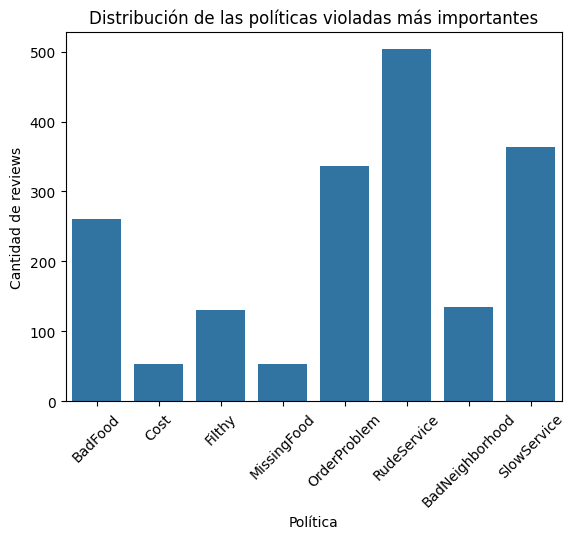

In [34]:
ax = sns.barplot(x='policy_violated', y='num_reviews', data=df_reviews_por_politica_violada)

ax.set_title('Distribución de las políticas violadas más importantes')
ax.set_xlabel('Política')
ax.set_ylabel('Cantidad de reviews')

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

In [35]:
print("Cantidad de reseñas de McDonalds donde no se detecto una violacion a una politica:", dummies.apply(lambda row: (row == 0).all(), axis=1).sum())

Cantidad de reseñas de McDonalds donde no se detecto una violacion a una politica: 349


Se concatena el df obtenido anteriormente con las infracciones de las politicas y la columna de reviews del dataset de McDonalds.

In [36]:
reviews_mcdonalds_ml = pd.concat([reviews_mcdolands['review'], dummies],axis=1)

In [37]:
reviews_mcdonalds_ml[reviews_mcdonalds_ml.review.str.len() <60].tail()

,review,BadFood,Cost,Filthy,MissingFood,OrderProblem,RudeService,BadNeighborhood,SlowService
1346,Impolite unfriendly staff on morning shift. Ba...,0,0,0,0,0,1,0,0
1381,There's really no reason for the employees to ...,0,0,0,0,0,1,0,0
1396,Stomach ache to go.,1,0,0,0,0,0,0,0
1482,They are open. Good service.,0,0,0,0,0,0,0,0
1495,"very good mcdonald's ,good service",0,0,0,0,0,0,0,0


## Obtencion de modelo de ML

### Obtencion de modelo base

Se toman 3 modelos que se consideran utiles para trabajar con las reviews y se analiza su performance mediante la metrica de F1 score.
El F1 Score es una métrica que combina la precisión y el recall, proporcionando un balance entre ambos. Es especialmente útil en estas situaciones, donde las clases están desbalanceadas. En el caso de la evaluación ‘micro’, se calcula el F1 Score global sumando los verdaderos positivos, falsos negativos y falsos positivos de todas las clases, y luego se calcula la precisión y el recall a partir de esos totales. Si algunas clases están subrepresentadas, el F1 Score puede dar una mejor idea del rendimiento del modelo que otras métricas como la precisión, que podría estar sesgada hacia las clases mayoritarias.
Ademas, es importante no solo la proporción de predicciones correctas (precisión), sino también la proporción de casos positivos reales detectados correctamente (recall).Usar el F1 Score micro asegura que se está evaluando el rendimiento del modelo de manera consistente para todas las clases, lo cual es crucial en clasificación multiclase.

Es importante mencionar tambien, que las reseñas se preprocesan mediante TfidfVectorizer para poder ser utilizadas en el modelo. Este metodo primero crea una matriz de terminos(palabras) para cada documento (cada review luego del preprocesamiento) utilizando el CountVectorizer (cuenta cada palabra en la review).
Luego, aplica la transformación TF-IDF a esa matriz de términos.
Frecuencia del término (TF): Mide la importancia de una palabra en un documento.
Frecuencia inversa de documentos (IDF): Evalúa la relevancia global de un término en todo el corpus (conjunto de documentos). Se calcula como el logaritmo del cociente entre el número total de documentos en el corpus y el número de documentos que contienen el término en cuestión. El IDF penaliza los términos que aparecen en muchos documentos y resalta aquellos que son más específicos.


In [38]:
# Preprocesamiento y vectorización
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', OneVsRestClassifier(RandomForestClassifier(n_estimators=100)))
])

# Validación cruzada
cv = KFold(n_splits=5, shuffle=True)
scorer = make_scorer(f1_score, average='micro')
scores_rf = cross_val_score(pipeline_rf, reviews_mcdonalds_ml['review'], reviews_mcdonalds_ml.iloc[:, 1:], cv=cv, scoring=scorer)

print(f"Random Forest F1 Scores: {scores_rf}")
print(f"Promedio F1 Score: {scores_rf.mean()}")

Random Forest F1 Scores: [0.28639618 0.31263383 0.29957806 0.34061135 0.29683698]
Promedio F1 Score: 0.3072112820225168


In [39]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

# Preprocesamiento y vectorización
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', OneVsRestClassifier(SVC(kernel='linear')))
])

# Validación cruzada
scores_svm = cross_val_score(pipeline_svm, reviews_mcdonalds_ml['review'], reviews_mcdonalds_ml.iloc[:, 1:], cv=cv, scoring=scorer)

print(f"SVM F1 Scores: {scores_svm}")
print(f"Promedio F1 Score: {scores_svm.mean()}")

SVM F1 Scores: [0.51102941 0.48979592 0.5428051  0.5037037  0.48846154]
Promedio F1 Score: 0.5071591344958889


In [40]:
from sklearn.naive_bayes import MultinomialNB

# Preprocesamiento y vectorización
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', OneVsRestClassifier(MultinomialNB()))
])

# Validación cruzada
scores_nb = cross_val_score(pipeline_nb, reviews_mcdonalds_ml['review'], reviews_mcdonalds_ml.iloc[:, 1:], cv=cv, scoring=scorer)

print(f"Naive Bayes F1 Scores: {scores_nb}")

Naive Bayes F1 Scores: [0.00554017 0.         0.01098901 0.0109589  0.01058201]


Se observa que de los tres modelos planteados, el que mejores resultados da es el de SVM.

El SVC es un algoritmo de aprendizaje supervisado que se utiliza para la clasificación binaria y multiclase. El parámetro C sirve como un parámetro de regularización que controla la compensación entre lograr un margen alto y asegurar que la mayoría de los puntos de entrenamiento estén clasificados correctamente. Un C bajo hace que la superficie de decisión sea suave, mientras que un C alto apunta a clasificar todos los ejemplos de entrenamiento correctamente. El SVC puede utilizar diferentes tipos de funciones kernel (como lineal, polinómico, RBF, sigmoidal) para transformar el espacio de entrada en un espacio de mayor dimensión donde es más probable que los datos sean linealmente separables.

El OneVsRestClassifier trabaja bajo el principio de entrenar un clasificador binario por cada clase. En el contexto de las reseñas de un restaurante, si tienes varias etiquetas como “BadFood”, BadService, etc., el modelo entrenará un clasificador para cada una de estas etiquetas contra todas las demás.

Por ejemplo, para la etiqueta “BadFood”, se entrenará un clasificador que diferencie las reseñas que mencionan específicamente un problema de la comida de aquellas que no lo hacen.

La utilidad de OneVsRestClassifier en la clasificación multietiqueta radica en su capacidad para manejar múltiples etiquetas simultáneamente. Al proporcionar una matriz indicadora como objetivo durante el entrenamiento, el modelo puede aprender a asignar múltiples etiquetas a una sola reseña. Esto es especialmente útil en reseñas de restaurantes, donde una sola reseña puede abarcar varios aspectos.

### Eleccion de hiperparametros

Una vez seleccionado el modelo base, se procedera a optimizar sus hiperparametros mediante la tencica del GridSearch. De esta forma, se prueban diferentes hiperparametros y se obtiene el modelo con la mejor combinacion de los mismos. GridSearchCV realiza una búsqueda exhaustiva sobre un conjunto de valores de parámetros que se define en param_grid e implementa la validación cruzada para evaluar el rendimiento de cada combinación de parámetros.

In [41]:
# Se dividen los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    reviews_mcdonalds_ml['review'],
    reviews_mcdonalds_ml.iloc[:, 1:],
    test_size=0.2,
    random_state=42
)

# Se definen los hiperparámetros a ajustar
param_grid = {
    'svm__estimator__C': [0.1, 1, 10],
    'svm__estimator__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'svm__estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Se crea el modelo con GridSearchCV
cv = KFold(n_splits=5, shuffle=True)
scorer = make_scorer(f1_score, average='micro')
grid_svm = GridSearchCV(pipeline_svm, param_grid, cv=cv, scoring=scorer)

# Se ajusta el modelo con los datos de entrenamiento
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svm',
                                        OneVsRestClassifier(estimator=SVC(kernel='linear')))]),
             param_grid={'svm__estimator__C': [0.1, 1, 10],
                         'svm__estimator__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'svm__estimator__kernel': ['linear', 'poly', 'rbf',
                                                    'sigmoid']},
             scoring=make_scorer(f1_score, average=micro))

In [42]:
# Obtener los mejores hiperparámetros
best_params = grid_svm.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Evaluar el modelo con los datos de prueba
y_pred = grid_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Mejores hiperparámetros: {'svm__estimator__C': 10, 'svm__estimator__gamma': 1, 'svm__estimator__kernel': 'linear'}
Accuracy: 0.380327868852459
F1 Score: 0.5292593262559984


In [43]:
with open('modelo_ML_negativas.pkl', 'wb') as archivo:
    pickle.dump(grid_svm, archivo)
# with open('modelo_6_topics.pkl', 'wb') as archivo:
#     pickle.dump(modelo_6_topic, archivo)

files.download('modelo_ML_negativas.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Aplicacion del modelo de ML a las reviews de Darden

Se genera una columna en el dataframe de reseñas de Darden donde se la etiquete a traves del modelo generado:

In [44]:
def predecir_etiqueta(review):
    return grid_svm.predict([review])[0]  # [0] para obtener el elemento de la lista

reviews_negativas_etiquetadas = reviews_negativas[['text','name','stars']]
reviews_negativas_etiquetadas['problem'] = reviews_negativas['text'].apply(predecir_etiqueta)
reviews_negativas_etiquetadas

,text,name,stars,problem
0,The service was terrible. My wife's meal came ...,Cheddar's Scratch Kitchen,1.0,"[0, 0, 0, 0, 0, 0, 0, 1]"
1,"Kitchen was very slow, 2 out of 8 meals serve...",Yard House,2.0,"[0, 0, 0, 0, 0, 0, 0, 1]"
2,I'm giving a 3 star because my mom liked her s...,Cheddar's Scratch Kitchen,3.0,"[0, 0, 0, 0, 1, 0, 0, 0]"
3,Liked the vegan options. A bit overpriced and ...,Yard House,3.0,"[0, 0, 0, 0, 0, 0, 0, 0]"
4,Good lunch. Great price for the lunch menu- we...,LongHorn Steakhouse,3.0,"[0, 0, 0, 0, 0, 0, 0, 1]"
...,...,...,...,...
7132,I guess this was bound to happen sooner or lat...,Bahama Breeze,1.0,"[0, 0, 0, 0, 0, 1, 0, 1]"
7133,Very disappointed this evening. Went to Longh...,LongHorn Steakhouse,1.0,"[0, 0, 0, 0, 0, 0, 0, 0]"
7141,"I took my Father, wife and children there to c...",LongHorn Steakhouse,1.0,"[0, 0, 0, 0, 0, 0, 0, 0]"
7148,I was never a fan of Olive Garden. I feel as i...,Olive Garden Italian Restaurant,3.0,"[1, 0, 0, 0, 0, 0, 0, 0]"


## Transformacion de los resultados para su visualizacion

### Grafico de barras

Se trabaja con la columna problem para desglosarla en 8 columnas, una para cada etiqueta, y se grafica la cantidad de reviews para cada etiqueta.

In [ ]:
nuevas_columnas = reviews_negativas_etiquetadas['problem'].apply(pd.Series)
nuevas_columnas.head()

In [ ]:
print("Cantidad de reseñas de Darden donde no se detecto una violacion a una politica:", nuevas_columnas.apply(lambda row: (row == 0).all(), axis=1).sum())

Se renombran las columnas con la problematica asocidada y se la concatena con el df de reviews negativas.

In [ ]:
reviews_negativas_etiquetadas = pd.concat([reviews_negativas_etiquetadas, nuevas_columnas], axis=1)
reviews_negativas_etiquetadas.rename(columns={0: 'bad_food', 1: 'cost', 2: 'filthy', 3: 'missing_food', 4: 'order_problem', 5: 'rude_service', 6: 'bad_neighborhood', 7: 'slow_service'}, inplace=True)

In [48]:
reviews_negativas_etiquetadas.head()

,text,name,stars,problem,bad_food,cost,filthy,missing_food,order_problem,rude_service,bad_neighborhood,slow_service
0,The service was terrible. My wife's meal came ...,Cheddar's Scratch Kitchen,1.0,"[0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,1
1,"Kitchen was very slow, 2 out of 8 meals serve...",Yard House,2.0,"[0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,1
2,I'm giving a 3 star because my mom liked her s...,Cheddar's Scratch Kitchen,3.0,"[0, 0, 0, 0, 1, 0, 0, 0]",0,0,0,0,1,0,0,0
3,Liked the vegan options. A bit overpriced and ...,Yard House,3.0,"[0, 0, 0, 0, 0, 0, 0, 0]",0,0,0,0,0,0,0,0
4,Good lunch. Great price for the lunch menu- we...,LongHorn Steakhouse,3.0,"[0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,1


Se crea un df con el conteo de reviews por cada problematica.

In [49]:
problems = reviews_negativas_etiquetadas[['bad_food','cost', 'filthy', 'missing_food', 'order_problem', 'rude_service', 'bad_neighborhood', 'slow_service']].sum()
df_problems = problems.reset_index()
df_problems.columns = ['problem', 'num_reviews']

Se grafica lo anterior en un grafico de barras.

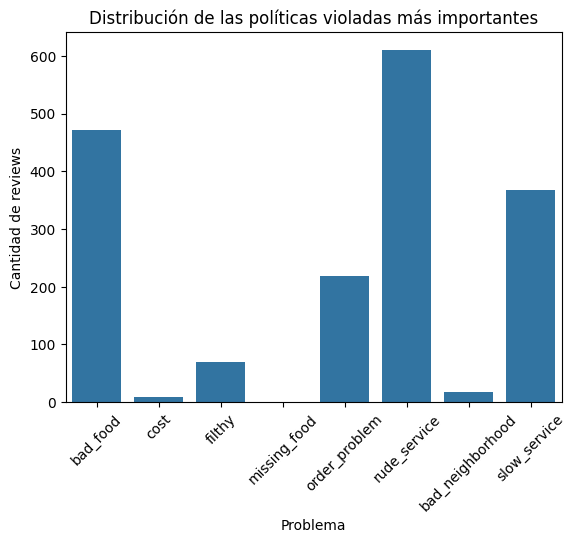

In [50]:
ax = sns.barplot(x='problem', y='num_reviews', data=df_problems)
ax.set_title('Distribución de las políticas violadas más importantes')
ax.set_xlabel('Problema')
ax.set_ylabel('Cantidad de reviews')
plt.xticks(rotation=45)
plt.show()

### Tabla de reseñas etiquetadas

Se obtiene una columna donde se indique todas las etiquetas para cada reseña.

In [51]:
nuevas_columnas.columns = ["Bad Food", "Cost", "Filthy", "Missing food", "Order problem", "Rude service", "Bad neighborhood", "Slow service"]
nuevas_columnas2 = nuevas_columnas.astype(bool)
nuevas_columnas2['problem'] = nuevas_columnas2.apply(lambda row: ', '.join(row.index[row]), axis=1)
reviews_etiquetadas_final = pd.concat([reviews_negativas_etiquetadas[['text','name','stars']], nuevas_columnas2['problem']], axis=1)
reviews_etiquetadas_final.tail(10)

,text,name,stars,problem
7111,I truly need to lower my expectations for casu...,Bahama Breeze,1.0,
7113,We randomly decided Friday night that we would...,LongHorn Steakhouse,2.0,
7116,"If you want a relaxing, enjoyable dining exper...",Eddie V's Prime Seafood,2.0,
7119,Its many chain restaurants to choose from in d...,Bahama Breeze,3.0,"Order problem, Slow service"
7122,I used to like Olive Garden up in New York.......,Olive Garden Italian Restaurant,1.0,"Bad Food, Rude service"
7132,I guess this was bound to happen sooner or lat...,Bahama Breeze,1.0,"Rude service, Slow service"
7133,Very disappointed this evening. Went to Longh...,LongHorn Steakhouse,1.0,
7141,"I took my Father, wife and children there to c...",LongHorn Steakhouse,1.0,
7148,I was never a fan of Olive Garden. I feel as i...,Olive Garden Italian Restaurant,3.0,Bad Food
7152,"1 star for serving two of us an allegedly ""dry...",Eddie V's Prime Seafood,1.0,


,text,name,stars,problem
7111,I truly need to lower my expectations for casu...,Bahama Breeze,1.0,
7113,We randomly decided Friday night that we would...,LongHorn Steakhouse,2.0,
7116,"If you want a relaxing, enjoyable dining exper...",Eddie V's Prime Seafood,2.0,
7119,Its many chain restaurants to choose from in d...,Bahama Breeze,3.0,"Order problem, Slow service"
7122,I used to like Olive Garden up in New York.......,Olive Garden Italian Restaurant,1.0,"Bad Food, Rude service"
7132,I guess this was bound to happen sooner or lat...,Bahama Breeze,1.0,"Rude service, Slow service"
7133,Very disappointed this evening. Went to Longh...,LongHorn Steakhouse,1.0,
7141,"I took my Father, wife and children there to c...",LongHorn Steakhouse,1.0,
7148,I was never a fan of Olive Garden. I feel as i...,Olive Garden Italian Restaurant,3.0,Bad Food
7152,"1 star for serving two of us an allegedly ""dry...",Eddie V's Prime Seafood,1.0,
